У меня нет репрезентативного кода кроме домашек в универе/в шаде, но вот как я только что разбирался, чем лучше решать олимпиадные задачи с "Я профессионал". Этот код был написан в предположении, что никто никогда на него не посмотрит, поэтому вместо общих определений и удобных переменных я копипастил старый код и оптимизировал только под свои временные затраты. Короче, это плохой код, да. 

Здесь я решаю задачу распознавания классификации слов по языкам.

## Препроцессинг


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
from transformers import CanineForSequenceClassification, CanineTokenizer
import torch

tokenizer = CanineTokenizer.from_pretrained("vicl/canine-c-finetuned-cola")
model = CanineForSequenceClassification.from_pretrained("vicl/canine-c-finetuned-cola", 
                                                        num_labels=20, 
                                                        ignore_mismatched_sizes=True,
                                                        problem_type="multi_label_classification")
model = model.to('cuda')

In [ ]:
path1 = '/content/drive/MyDrive/Colab Notebooks/Language_detection'

In [ ]:
labels = "bg,cs,da,de,el,es,et,fi,fr,hu,it,lt,lv,nl,pl,pt,ro,sk,sl,sv".split(',')
label2id = {}
id2label = {}
for i in range(len(labels)):
  id2label[i] = labels[i]
  label2id[labels[i]] = i

In [ ]:
import os
import string
from tqdm import tqdm
data_t = []
symb_set = set([])
for name in tqdm(os.listdir(path1)):
    with open(path1+'/'+name, 'r', encoding='utf-8') as l:
      if name[:5] != 'train':
        continue
      exclude = set(string.punctuation) - set('\'')
      s = ''.join(ch for ch in l.read() if ch not in exclude)
      symb_set.update(set(s))

      x = [w.lower() for w in s.split()]      
      label = [label2id[name[-2:]]]*len(x)
      data_t = data_t + list(zip(x, label))
n_tokens = len(symb_set)+2

100%|██████████| 24/24 [00:29<00:00,  1.24s/it]


In [ ]:
# pad=0, unk=1
char2id = {c:i+2 for i,c in enumerate(symb_set)}
char2id['pad']=0
char2id['unk']=1
id2char = {i:c for c,i in char2id.items()}

In [ ]:
import pandas as pd
df = pd.DataFrame(data_t, columns=['input_ids', 'labels'])
df

,input_ids,labels
0,c'est,8
1,en,8
2,effet,8
3,tout,8
4,à,8
...,...,...
6574155,i,19
6574156,feira,19
6574157,mitt,19
6574158,sista,19


In [ ]:
!pip install datasets
from datasets import Dataset
train = Dataset.from_pandas(df)
type(train), train

In [ ]:
train = train.train_test_split(test_size=0.05)
type(train), type(train['train']), train

(datasets.dataset_dict.DatasetDict,
 datasets.arrow_dataset.Dataset,
 DatasetDict({
     train: Dataset({
         features: ['input_ids', 'labels'],
         num_rows: 6245452
     })
     test: Dataset({
         features: ['input_ids', 'labels'],
         num_rows: 328708
     })
 }))

## Тренировка + валидация Canine двумя способами

In [ ]:
#@title Train версия 1
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn.functional as F
%matplotlib inline

device='cuda'

train_dataloader = torch.utils.data.DataLoader(train["train"], batch_size=256, 
                                               shuffle=True, 
                                               )
metrics = []
def training(model=model, tokenizer=tokenizer, dataloader = train_dataloader):
  model.train()
  for batch in tqdm(dataloader):
    step = len(metrics) + 1
    ids = tokenizer(batch['words'], padding=True, return_tensors="pt").to(device)
    onehot_labels = F.one_hot(torch.tensor(batch['labels']), 
                              num_classes=20).to(torch.float).to(device)
    loss = model(**ids, labels=onehot_labels).loss
    opt.zero_grad()
    loss.backward()
    opt.step()    
    metrics.append((step, loss.item()))


    if step % 50 == 0:        
        clear_output(True)
        plt.figure(figsize=(12,4))
        plt.title('loss')
        plt.plot(*(zip(*metrics)))
        plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics[-10:], axis=0)[1], flush=True)

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

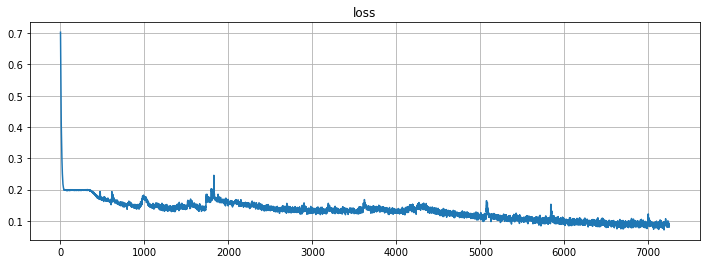

Mean loss=0.088


 30%|██▉       | 7289/24397 [46:58<1:50:15,  2.59it/s]


KeyboardInterrupt: ignored

In [ ]:
for ep in range(1):
  training()

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            }, '/content/drive/MyDrive/Colab Notebooks/Language_detection/ckpt2')

## Train Canine верия 2

In [ ]:
from transformers import DataCollatorWithPadding
import torch.nn.functional as F
from collections import defaultdict
from tqdm import tqdm

device='cuda'
class data_collator:
  def __init__(self, to_pad=['input_ids'], tokenizer=tokenizer, device='cuda'):
      self.to_pad = set(to_pad)
      self.device = device

  def __call__(self, batch):
      padded_batch0 = defaultdict(list)
      for example in batch:
          for key, tensor in example.items():
              padded_batch0[key].append(tensor)
      padded_batch = padded_batch0.copy()
      for key, val in padded_batch0.items():
          if key in self.to_pad:
              cols = tokenizer(val, padding=True)
              for col, v in cols.items():
                padded_batch[col] = torch.LongTensor(v)
      onehot_labels = F.one_hot(torch.tensor(padded_batch['labels']), 
                              num_classes=20).to(torch.float).to(device)          
      padded_batch['labels'] = onehot_labels
      padded_batch = Dataset.from_dict(padded_batch)
      padded_batch.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
      return padded_batch[:]

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="checkpoints_31_last", 
                                  learning_rate=1e-3,
                                  per_device_train_batch_size=256,
                                  num_train_epochs=1,
                                  logging_steps=100000,
                                  save_total_limit=1,
                                 ) 

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train['train'],
    tokenizer=tokenizer,
    data_collator = data_collator(device='cuda'),
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 6245452
  Num Epochs = 1
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 24397
  Number of trainable parameters = 132098324


Step,Training Loss
500,0.200800
1000,0.199000


Saving model checkpoint to checkpoints_31_last/checkpoint-500
Configuration saved in checkpoints_31_last/checkpoint-500/config.json
Model weights saved in checkpoints_31_last/checkpoint-500/pytorch_model.bin
tokenizer config file saved in checkpoints_31_last/checkpoint-500/tokenizer_config.json
Special tokens file saved in checkpoints_31_last/checkpoint-500/special_tokens_map.json
Saving model checkpoint to checkpoints_31_last/checkpoint-1000
Configuration saved in checkpoints_31_last/checkpoint-1000/config.json
Model weights saved in checkpoints_31_last/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in checkpoints_31_last/checkpoint-1000/tokenizer_config.json
Special tokens file saved in checkpoints_31_last/checkpoint-1000/special_tokens_map.json


KeyboardInterrupt: ignored

In [ ]:
dl = trainer.get_train_dataloader()
for data in dl:
  y = {k: trainer._prepare_input(v) for k,v in data[:].items()}
  print(type(train)(y))
  # y = trainer._prepare_input(x)
  break

[[57344, 117, 110, 100, 101, 57345], [57344, 107, 111, 109, 109, 105, 116, 57345], [57344, 112, 97, 114, 57345], [57344, 100, 39, 97, 106, 111, 117, 114, 110, 101, 109, 101, 110, 116, 57345], [57344, 110, 111, 117, 259, 57345], [57344, 949, 943, 957, 945, 953, 57345], [57344, 115, 117, 105, 118, 105, 57345], [57344, 112, 111, 117, 114, 57345], [57344, 97, 108, 115, 57345], [57344, 228, 103, 110, 97, 114, 57345], [57344, 959, 57345], [57344, 105, 108, 57345], [57344, 105, 110, 102, 111, 114, 109, 257, 99, 105, 106, 117, 57345], [57344, 112, 97, 114, 108, 101, 109, 101, 110, 116, 57345], [57344, 113, 117, 101, 57345], [57344, 111, 104, 117, 116, 117, 115, 101, 101, 115, 107, 105, 114, 106, 97, 100, 101, 57345]]
DatasetDict({
    input_ids: [[57344, 117, 110, 100, 101, 57345], [57344, 107, 111, 109, 109, 105, 116, 57345], [57344, 112, 97, 114, 57345], [57344, 100, 39, 97, 106, 111, 117, 114, 110, 101, 109, 101, 110, 116, 57345], [57344, 110, 111, 117, 259, 57345], [57344, 949, 943, 957, 9

In [ ]:
predicted_labels = []
test_dataloader = torch.utils.data.DataLoader(train["test"], batch_size=512, 
                                              shuffle=False,
                                              # collate_fn=PadSequence(['words'])
                                              )

In [ ]:
for batch in tqdm(test_dataloader):
  x  = tokenizer(batch['words'], return_tensors="pt", padding=True).to(device)
  with torch.no_grad():
    model.eval()
    x = model(**x).logits.argmax(-1)
  predicted_labels.extend(x)

100%|██████████| 643/643 [02:59<00:00,  3.59it/s]


In [ ]:
for i, x in enumerate(predicted_labels):
  predicted_labels[i] = int(x)

In [ ]:
acc = np.sum(np.array(predicted_labels)==np.array(train['test']['labels']))/len(predicted_labels)
acc

0.6574923640434671

## Тренировка LSTM

In [ ]:
from torch.nn import LSTM
from torch import nn

class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens+5, emb_size=128, hid_size=32):
        super().__init__() 
                
        self.emb = torch.nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
        self.lstm = torch.nn.LSTM(input_size=emb_size, hidden_size=hid_size, num_layers=2, batch_first=True)
        self.dense = torch.nn.Linear(hid_size, 20)
    
    def __call__(self, input_ix):

        v = self.emb(input_ix)
        v,_ = self.lstm(v)
        v = v[:,-1,:]
        v = self.dense(v)

        return v 

In [ ]:
from collections import defaultdict
import numpy as np
train_history, dev_history = [], []
device = 'cuda'

model = RNNLanguageModel().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

def to_matrix(lines, max_len=None, pad=char2id['pad'], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = np.array(list(map(char2id.get, list(lines[i])[:max_len])))
        line_ix[line_ix==None] = 1 
        
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

def collate_fn(batch):
  padded = defaultdict(torch.LongTensor)
  labels=[]
  for element in batch:
    labels.append(element['labels'])
  padded['labels'] = torch.LongTensor(labels)

  lines = []
  for element in batch:
    lines.append(element['input_ids'])
  padded['input_ids'] = torch.LongTensor(to_matrix(lines))
  return padded

train_dataloader = torch.utils.data.DataLoader(train["train"], batch_size=512, 
                                               shuffle=True, 
                                               collate_fn = collate_fn,
                                               )

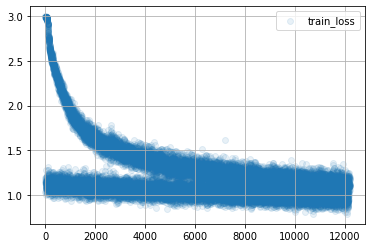

100%|██████████| 12199/12199 [12:48<00:00, 15.88it/s]


In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange, tqdm
from torch.nn import CrossEntropyLoss as CEloss
import matplotlib.pyplot as plt

model.train()
for i,batch in enumerate(tqdm(train_dataloader)):
    ids = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)
    
    loss = CEloss()(model(ids), labels)

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    train_history.append((i, float(loss)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()

In [ ]:
predicted_labels = []
test_dataloader = torch.utils.data.DataLoader(train["test"], batch_size=512, 
                                              shuffle=False,
                                              collate_fn=collate_fn,
                                              )
model.eval()
for batch in tqdm(test_dataloader):
  with torch.no_grad():
    x = model(batch['input_ids'].to('cuda')).argmax(-1).detach().cpu().numpy()
  predicted_labels.extend(x)

for i, x in enumerate(predicted_labels):
  predicted_labels[i] = int(x)

acc = np.sum(np.array(predicted_labels)==np.array(train['test']['labels']))/len(predicted_labels)
acc

100%|██████████| 643/643 [00:26<00:00, 24.17it/s]


0.6783071905764386

## Тренировка LSTM поболбше

In [ ]:
from torch.nn import LSTM
from torch import nn

class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens+5, emb_size=256, hid_size=128):
        super().__init__() 
                
        self.emb = torch.nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
        self.lstm = torch.nn.LSTM(input_size=emb_size, hidden_size=hid_size, num_layers=4, batch_first=True)
        self.dense = torch.nn.Linear(hid_size, 20)
    
    def __call__(self, input_ix):

        v = self.emb(input_ix)
        v,_ = self.lstm(v)
        v = v[:,-1,:]
        v = self.dense(v)

        return v 

model = RNNLanguageModel().to('cuda')
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

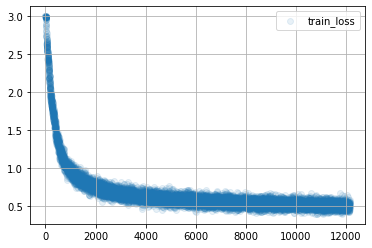

100%|██████████| 12199/12199 [14:49<00:00, 13.71it/s]


In [ ]:
import numpy as np
train_history, dev_history = [], []
device = 'cuda'

model.train()
for i,batch in enumerate(tqdm(train_dataloader)):
    ids = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)
    
    loss = CEloss()(model(ids), labels)

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    train_history.append((i, float(loss)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()

In [ ]:
predicted_labels = []
test_dataloader = torch.utils.data.DataLoader(train["test"], batch_size=512, 
                                              shuffle=False,
                                              collate_fn=collate_fn,
                                              )
model.eval()
for batch in tqdm(test_dataloader):
  with torch.no_grad():
    x = model(batch['input_ids'].to('cuda')).argmax(-1).detach().cpu().numpy()
  predicted_labels.extend(x)

for i, x in enumerate(predicted_labels):
  predicted_labels[i] = int(x)

acc = np.sum(np.array(predicted_labels)==np.array(train['test']['labels']))/len(predicted_labels)
acc

100%|██████████| 643/643 [00:40<00:00, 15.77it/s]


0.8012278374727722

## LSTM  с большими размерностями

In [ ]:
from torch.nn import LSTM
from torch import nn
from IPython.display import clear_output
from random import sample
from tqdm import trange, tqdm
from torch.nn import CrossEntropyLoss as CEloss
import matplotlib.pyplot as plt

class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens+5, emb_size=512, hid_size=256):
        super().__init__() 
                
        self.emb = torch.nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
        self.lstm = torch.nn.LSTM(input_size=emb_size, hidden_size=hid_size, num_layers=3, batch_first=True)
        self.dense = torch.nn.Linear(hid_size, 20)
    
    def __call__(self, input_ix):

        v = self.emb(input_ix)
        v,_ = self.lstm(v)
        v = v[:,-1,:]
        v = self.dense(v)

        return v 

model = RNNLanguageModel().to('cuda')
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

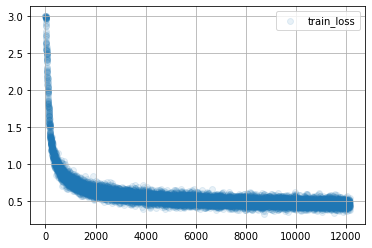

100%|██████████| 12199/12199 [16:46<00:00, 12.12it/s]


In [ ]:
import numpy as np
train_history, dev_history = [], []
device = 'cuda'

model.train()
for i,batch in enumerate(tqdm(train_dataloader)):
    ids = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)
    
    loss = CEloss()(model(ids), labels)

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    train_history.append((i, float(loss)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()

In [ ]:
predicted_labels = []
test_dataloader = torch.utils.data.DataLoader(train["test"], batch_size=512, 
                                              shuffle=False,
                                              collate_fn=collate_fn,
                                              )
model.eval()
for batch in tqdm(test_dataloader):
  with torch.no_grad():
    x = model(batch['input_ids'].to('cuda')).argmax(-1).detach().cpu().numpy()
  predicted_labels.extend(x)

for i, x in enumerate(predicted_labels):
  predicted_labels[i] = int(x)

acc = np.sum(np.array(predicted_labels)==np.array(train['test']['labels']))/len(predicted_labels)
acc

100%|██████████| 643/643 [00:39<00:00, 16.14it/s]


0.8110602723389756